In [1]:
import numpy as np
import scipy.stats, sys
import itertools

import matplotlib.pyplot as plt
sys.path.append('/home/jp/projects/python_tools') # This is just a plotting tool
import jp_mpl as jplot
%matplotlib inline   


In [22]:
def histchi2(data, pdf):
    return np.sum((data - pdf)**2/pdf)

### Assume you are analyzing a zenith distribution
#### Define a number of bins, sample size and shape of the distribution. All these should be irrelevant. It is just to make it more comprehensible

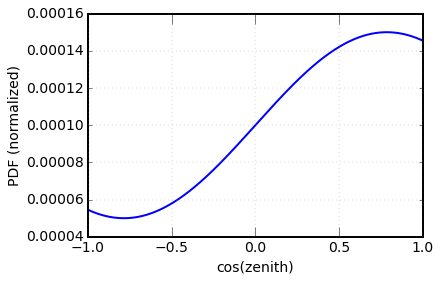

In [92]:
# cos(zenith) edges
xedges = [-1,1]
# Number of bins
xbins  = 24
# The z-axis of all histograms
zaxis  = np.linspace(xedges[0],xedges[1], xbins+1)

# The size of our experiment
events_to_draw = 100

# Our infinite MC - it just has to be huge in comparison to the events "observed"
zenith = np.linspace(xedges[0],xedges[1], events_to_draw*100)

# This is the shape of the distribution. I just wanted to avoid it being flat and having zero bins
# You can modify it at will. Just make it positive
true_pdf  = 2.+np.sin(zenith*2)
true_pdf *= 1/np.sum(true_pdf)
plt.plot(zenith, true_pdf)
plt.xlabel('cos(zenith)')
plt.ylabel('PDF (normalized)')

plt.show()

### Get some events from your infinite MC - that's your data

Chi2  25.5758533325


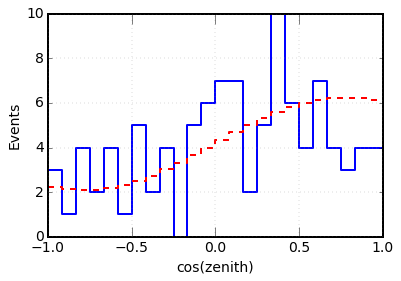

In [93]:
# Draw some events from that true pdf without replacement
data = np.random.choice(zenith, 
                        events_to_draw, 
                        replace=False,
                        p = true_pdf)

# Compare the true values between your events and the infinite MC
dbins, x = np.histogram(data, zaxis)
jplot.unfilledBar(zaxis, dbins)

perfect_data = true_pdf*events_to_draw
perfbins, x = np.histogram(zenith, zaxis, weights=perfect_data)
jplot.unfilledBar(zaxis, perfbins, linestyle='--', color='red')
plt.xlabel('cos(zenith)')
plt.ylabel('Events')


chi2 = np.sum((perfbins-dbins)**2/perfbins)
print 'Chi2 ', chi2

### Define your reconstruction parameters - including the unstable behavior

In [94]:
# Let's reconstruct that data N times
nrecos = 10

# These parameters are the usual ones for a reconstruction
fit_bias      = 0.03
fit_sigma     = 0.05

# This parameter is the stability. Changes for every event, every time it is reconstructed
fit_stability = 0.3
fit_stability_bias = 0.1

### Reconstruct your infinite MC - with and without unstable behavior. Bin it.

In [95]:
# Let's get the reconstructed PDF using only the perfect reco
reco_pdf = zenith+np.random.normal(fit_bias, fit_sigma, zenith.shape)
reco_hist, x = np.histogram(reco_pdf, zaxis, weights=perfect_data)

# Now let's reconstruct the PDF using perfect reco + unstable behavior
unstable_pdf = reco_pdf+np.random.normal(fit_stability_bias, fit_stability, zenith.shape)
unstable_hist, x = np.histogram(unstable_pdf, zaxis, weights=perfect_data)

### Reconstruct the "data" - with and without unstable behavior 

In [96]:
# First the normal reco - well defined
reco_resolution = np.random.normal(fit_bias, fit_sigma, data.shape)

# Then the reco stability - changes every time
reco_stability = np.random.normal(fit_stability_bias, fit_stability, (nrecos,len(data)))

# Reconstruction (stable behavior)
perfect_reco = data+reco_resolution

# Reconstruction (with unstable behavior)
myreco = reco_stability+data+reco_resolution

### Expected statistical precision to normalization

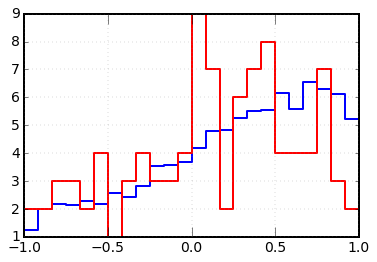

In [97]:
jplot.unfilledBar(zaxis, reco_hist)
n, x = np.histogram(perfect_reco, zaxis)
jplot.unfilledBar(zaxis, n, color = 'red')

In [102]:
# Calculate chi2 of 2 histograms
nvalues = np.linspace(0.9, 1.2, 101)
chi2values = np.zeros_like(nvalues)
for i, value in enumerate(nvalues):
    chi2values[i] = histchi2(n, value*reco_hist)

(0.9, 1.2)

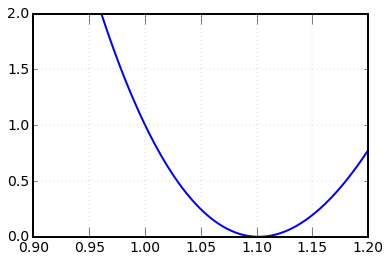

In [103]:
plt.plot(nvalues, chi2values-chi2values.min())
plt.ylim([0, 2])
plt.xlim([0.9, 1.2])

### Verification - resolution with/without instability

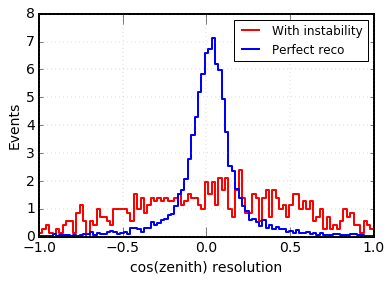

In [104]:
# Verifying resolutions
raxis = np.linspace(-1, 1, 100)
resolution = (reco_pdf - zenith)/zenith
r, newx = np.histogram(resolution, raxis , weights=perfect_data)

resolution_unstable = ((myreco - data)/data).flatten()
r2, newx = np.histogram(resolution_unstable, raxis)

jplot.unfilledBar(newx,r2*np.sum(r)/np.sum(r2), color = 'red', label='With instability')
jplot.unfilledBar(newx,r, label='Perfect reco')
plt.legend(loc=0)
plt.ylabel('Events')
plt.xlabel('cos(zenith) resolution')

### Verify one of the 10 reconstructions

Chi2 vs stable  19.3059319024
Chi2 vs unstable  21.2187655627


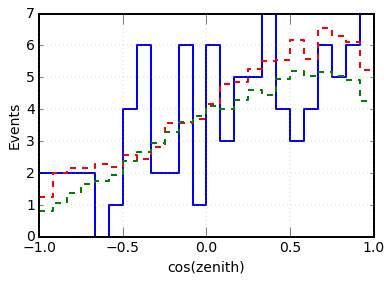

In [105]:
# Compare the i-th reconstruction
i = 4

one_reco, x = np.histogram(myreco[i,:], zaxis)
jplot.unfilledBar(x, one_reco)
jplot.unfilledBar(zaxis, reco_hist, linestyle='--', color='red')
jplot.unfilledBar(zaxis, unstable_hist, linestyle='--', color='green')
chi2 = np.sum((one_reco - reco_hist)**2/reco_hist)
chi2u= np.sum((one_reco - unstable_hist)**2/unstable_hist)
plt.xlabel('cos(zenith)')
plt.ylabel('Events')
print 'Chi2 vs stable ', chi2
print 'Chi2 vs unstable ', chi2u

In [106]:
# Calculate the chi2 of all re-reconstructions
norms = []
nvalues = np.linspace(0.97, 1.03, 201)
for i in range(myreco.shape[0]):
    chi2values = np.zeros_like(nvalues)
    for iv, value in enumerate(nvalues):
        n, x = np.histogram(myreco[i,:], zaxis)
        chi2values[iv] = histchi2(n, value*unstable_hist)
    norms.append(nvalues[chi2values.argmin()])

In [107]:
print np.std(norms)

2.22044604925e-16


### Histogram all of the data

In [9]:
# Calculate the relative errors of each MC with respect to all of them
# Get the histograms

data_histograms = np.zeros([myreco.shape[0], len(zaxis)-1])
for i in range(myreco.shape[0]):
    data_histograms[i,:], x = np.histogram(myreco[i,:], zaxis)

In [10]:
data_histograms.shape

(10, 24)

In [11]:
# Now get the deviations for each histogram wrt all the others
deviations = np.zeros([myreco.shape[0], (myreco.shape[0]-1)*data_histograms.shape[1]])
for i in range(myreco.shape[0]):
    alldevs = (data_histograms[i,:] - data_histograms)/data_histograms
    
    deviations[i,:] = np.concatenate((alldevs[:i,:].flatten(), alldevs[(i+1):, :].flatten()))

[ 0.75352904  1.44970037  0.89671386  0.56519317  1.03673061  2.68359661
  1.19750543 -0.48610678  0.72560013  1.66825639]
7


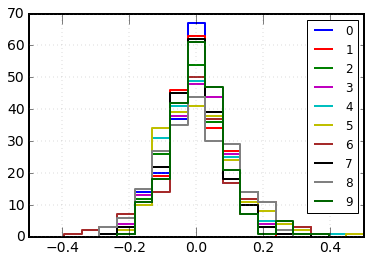

In [12]:
plt.plot()
mycolors = ['b','r','g','m','c','y','brown', 'k', '0.5','darkgreen','darkred']
color = itertools.cycle(mycolors)
devaxis = np.linspace(-0.5, 0.5, 20)
for i in range(myreco.shape[0]):
    n, x = np.histogram(deviations[i,:], devaxis)
    jplot.unfilledBar(x, n, color = color.next(), label = str(i))
plt.legend(loc=0)
devsum = np.sum(deviations, axis=1)
print devsum
print np.abs(devsum).argmin()
#plt.yscale('log')

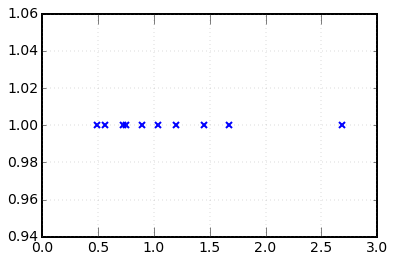

In [14]:
plt.plot(np.abs(devsum), [1.]*len(devsum), 'x')

In [ ]:
# I still need to make a fit to make my point clear
# Let's just get the prediction for the normalization as my parameter

In [60]:
unstable_pdf.shape

(500000,)